# 1. Explore the Data
# 2. Architecture: Unet
# 3. Training and Testing
# 4. Hyperparamter Optimization with Optuna
# 5. Postprocessing

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline


from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F


import optuna
from torchsummary import summary
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A  
from albumentations.pytorch import ToTensorV2


#utils
import os
from tqdm.notebook import tqdm
import time
import random
import joblib
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings('ignore') 
from IPython.display import display

In [2]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Not connected to a GPU')
# else:
#     print(gpu_info)

# 1. Explore the Data

In [3]:
class_list = pd.read_csv('Aerial_Image_Data/class_dict_seg.csv')
n_classes = 23
image_path = 'Aerial_Image_Data/original_images/'
mask_path = 'Aerial_Image_Data/label_images_semantic/'
rgb_mask_path='Aerial_Image_Data/rgb_color_image_masks/'
ext_dir = 'Results/'

In [4]:
def Names2DataFrame(image_path):
    name_list = []
    for root, dirs, files in os.walk(image_path):
        for filename in files:
            name_list.append(filename.split('.')[0])
    df = pd.DataFrame(name_list,columns=['ID'])
    return df
df = Names2DataFrame(image_path)

In [5]:
X_train, X_test = train_test_split(df['ID'].values, test_size = 0.2, random_state=19)
print(len(X_train))
print(len(X_test))

320
80


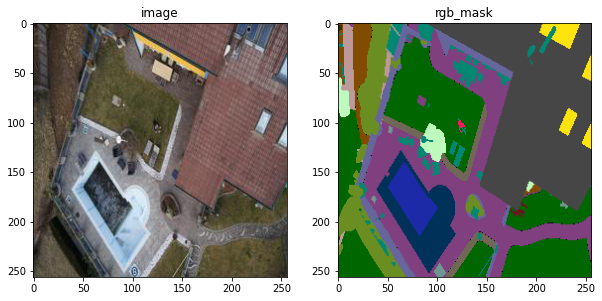

In [6]:
#display a sample image with its mask.
i =  random.randint(0,len(df))
img1 =  Image.open(image_path + df['ID'][i]+'.jpg').convert('RGB')
mask1 = Image.open(rgb_mask_path + df['ID'][i]+'.png').convert('RGB')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,7))
ax1.imshow(img1)
ax1.set_title('image');

ax2.imshow(mask1)
ax2.set_title('rgb_mask')
fig.show()

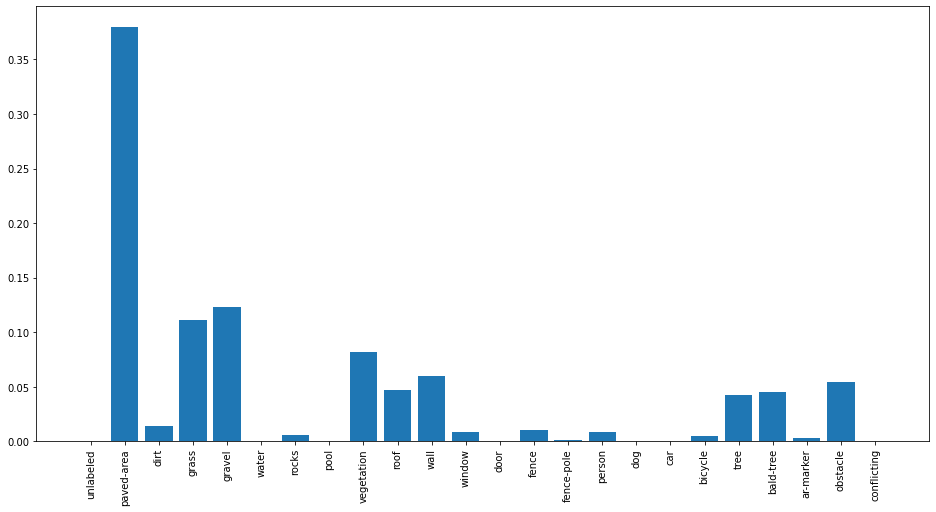

In [7]:
def ShowClassFrequency(mask_path, df,class_list,sample_size=4):
    random_inds = np.random.randint(0,len(df),size = sample_size)
    class_count = np.array([])
    for cls in range(n_classes+1):
        c = 0
        for idx in random_inds:
            mask = Image.open(mask_path + df['ID'][idx]+'.png').convert('L')
            c += np.count_nonzero(np.array(mask)==cls)
        class_count = np.append(class_count,c)

    fig = plt.figure(figsize=(16,8))
    plt.bar(class_list[class_list.columns[0]], class_count/np.sum(class_count))
    plt.xticks(fontsize=10, rotation=90)
    plt.show()

ShowClassFrequency(mask_path,df,class_list)

In [8]:
def ResizeSave(raw_dir,dest_dir,dim=(256,256),mask = False):
    for image_name in os.listdir(raw_dir):
        inputPath = os.path.join(raw_dir, image_name)
        if mask:
            img = Image.open(inputPath).convert('L')
        else:
            img = Image.open(inputPath).convert('RGB')
        img = img.resize(dim,Image.NEAREST)
        save_path = os.path.join(dest_dir, image_name)
        img = img.save(save_path)
    
    print('Resizing done')

## 2. Architecture: Unet

- As usual, data must be prepared for training. This step is fairly standard for most of image applications in Pytorch. We first define a new class AiralImageDataset on the top of Pytorch's Dataset class. Then create train and test loader via DataLoader class.

- Concerning the image augmentation, **we must be very careful about what type of transformation we apply on masks**. Rule of thumb, we must keep the mask aligned with the original image. Thus, operations such as resizing, rotating, flipping etc. must be applied both the image and the mask. However, pixel-wise operations such as adding noise, normalizing **CANNOT** be applied to mask as it represents TRUE label of each pixel as an "integer" value.
- I included few augmentation provided by [Albumentation](https://albumentations.ai/) library but more can be easily integrated if needed. Albumentation is faster than native torchvision as documented in their website.  
- I will train only naive Unet which is probably one of most well-known arhitecture. Have a look at the original paper [here](https://arxiv.org/abs/1505.04597). In the second part of this notebook, I will focus on three pretrained models. 


In [9]:
class AiralImageDataset(Dataset):
    
    def __init__(self, img_path, mask_path, image_list, train):
        self.img_path = img_path
        self.mask_path = mask_path
        self.image_list = image_list
        self.train = train
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        
        mean = [0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
        img = Image.open(self.img_path + self.image_list[idx] + '.jpg').convert('RGB')
        mask = Image.open(self.mask_path + self.image_list[idx] + '.png').convert('L')
        
        #albumentation accepts numpy images
        img = np.array(img)
        mask = np.array(mask)
            
        #augmentation for training set
        if self.train:
            #augmentation for image and mask
            tfm = A.Compose([A.HorizontalFlip(p=0.5),A.VerticalFlip(p=0.5)])
            aug = tfm(image = img,mask = mask) 
            img = aug['image']
            mask = aug['mask']
            #augmentation only for image!
            tfm = A.Compose([#A.GridDistortion(p=0.2),
                             #A.GaussNoise(p=0.2),
                             A.Normalize(mean, std)])
            img = tfm(image=img)['image'] 
        
        #augmentation for testing set
        else:
            tfm = A.Normalize(mean, std)
            img = tfm(image=img)['image']
        
        tfm = ToTensorV2()
        aug = tfm(image=img,mask=mask)
        img = aug['image']
        mask = aug['mask']
        mask = mask.type(torch.LongTensor)
        
        return img,mask

In [10]:
def GetLoaders(train_batch_size,test_batch_size):
    
    train_set = AiralImageDataset(image_path,mask_path,X_train,train=True)
    train_loader = DataLoader(train_set, batch_size = train_batch_size,shuffle=True,drop_last=True,num_workers=1)
    
    test_set  =   AiralImageDataset(image_path,mask_path,X_test,train=False)
    test_loader  = DataLoader(test_set, batch_size = test_batch_size,drop_last=True,num_workers=1)

    return train_loader, test_loader

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1,bias=False),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class BaseUnet(nn.Module):
    features=[64, 128, 256, 512] #original one
    #features = [16, 32, 64, 128]
    def __init__(self, features = features, in_channels=3, n_classes = 23):
        super(BaseUnet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder 
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.decoder.append(DoubleConv(feature*2, feature))

        self.bottom = DoubleConv(features[-1], features[-1]*2)
        self.out_conv = nn.Conv2d(features[0], n_classes, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down_conv in self.encoder:
            x = down_conv(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottom(x)
        skip_connections = skip_connections[::-1]
        
        # down-sample--> add_connections --> apply 2D conv

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](concat_skip)

        return self.out_conv(x)

In [12]:
model = BaseUnet().to(device)
summary(model,(3,256,256))
torch.cuda.empty_cache()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,864
              ReLU-4         [-1, 64, 256, 256]               0
        DoubleConv-5         [-1, 64, 256, 256]               0
         MaxPool2d-6         [-1, 64, 128, 128]               0
            Conv2d-7        [-1, 128, 128, 128]          73,728
              ReLU-8        [-1, 128, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]         147,456
             ReLU-10        [-1, 128, 128, 128]               0
       DoubleConv-11        [-1, 128, 128, 128]               0
        MaxPool2d-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         294,912
             ReLU-14          [-1, 256,

# 3. Training and Testing
- In this section, driver functions for training and testign are defined. Our metric for training is intersection-over-union error. Carefully note that pixel accuracy is not a representative measure for the quality of the model as majority of the pixels belong to a one or two classes. More details can be found in the post by Jeremy Jordan [here](https://www.jeremyjordan.me/evaluating-image-segmentation-models/). This metric can be considered as a loss function as well with some modification as depicted below. I directly use from [here](https://github.com/amirhosseinh77/UNet-AerialSegmentation/blob/main/losses.py) where different cost function defintions can be found.
- It is important to save and load the best models whenever needed with their respective states. Two functions defined below serve this purpose.

In [13]:
def GetPixelAccuracy(outputs,mask):
    with torch.no_grad():
        #get HxW class predictions
        preds = F.softmax(outputs, dim=1)
        preds = torch.argmax(preds, dim=1)
        correct = torch.eq(preds, mask).int()
        pixel_accuracy = float(correct.sum()) / float(correct.numel())
    
    return pixel_accuracy

In [14]:
#IOU = TP/(TP+FP+FN)  
def GetIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)

        iou_per_class = []
        for clas in range(0, n_classes):    #loop per pixel class
            pred_class = pred_mask == clas  # predicted boolen class
            true_label = mask == clas       # boolen true labels

            if true_label.sum().item() == 0: #cls not present
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(pred_class, true_label).sum().float().item()
                union = torch.logical_or(pred_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
                
        return np.nanmean(iou_per_class)

In [15]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=23):
        super(IoULoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        inter = inputs * target_oneHot
        
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)

        #Denominator 
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return 1-loss.mean()

In [16]:
def SaveModel(model,optimizer, name,beststats):
    checkpoint = { 'state_dict':  model.state_dict(),
                   'optim_state': optimizer.state_dict(),
                   'best_stats':  beststats
                 }
    path = ext_dir + "/" + name +".pth"
    torch.save(checkpoint, path )

In [17]:
def LoadModel(model,filepath,train_mode = False):
    #load the model and assign the pre-trained weights
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    model.best_scores = checkpoint['best_stats']
    
    #if train required
    if train_mode:        
        for parameter in model.parameters():
            parameter.requires_grad = False
        optimizer.load_state_dict(checkpoint['optim_state'])
        
        return model,optimizer
    
    else:
        return model

In [18]:
def TrainModel(trial, model,train_loader,criterion, optimizer,batch_size,epoch,log_int):    
    model.to(device)
    model.train()
    train_loss = 0
    iou_score = 0.
    pixel_acc = 0.
    #training loop     
    for i,(images, masks) in enumerate(train_loader):
        torch.cuda.empty_cache()
        images = images.to(device);
        masks = masks.to(device);

        #forward
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        #evaluation metrics
        iou_score += GetIoU(outputs, masks)
        pixel_acc += GetPixelAccuracy(outputs, masks)

        #backward
        loss.backward()       #evaluate gradients
        optimizer.step()      #update weight          
        optimizer.zero_grad() #reset gradient

        train_loss += loss.item()


    avg_train_loss = train_loss/len(train_loader) 
    avg_iou_score = iou_score/len(train_loader)
    avg_pixel_acc = pixel_acc/len(train_loader)
    
    if epoch%log_int==0:
        print(f'Epoch:{epoch} TrainIoU: {avg_iou_score:0.4f}\n')
    
    trial.report(epoch,avg_iou_score)
    if trial.should_prune():
        print(f'Pruned when acc:{avg_iou_score:0.4f} epoch: {epoch}\n')
        raise optuna.TrialPruned()

    return avg_iou_score

In [19]:
def TestModel(model,test_loader,criterion,epoch,log_int):
    torch.cuda.empty_cache()
    model.to(device)
    model.eval()
    with torch.no_grad():
        test_loss = 0
        iou_score = 0.
        pixel_acc = 0.
        for i,(images, masks) in enumerate(test_loader):         
            images = images.to(device);
            masks = masks.to(device);

            #forward
            outputs = model(images)
            loss = criterion(outputs, masks)

            #evaluation metrics
            test_loss += loss.item()
            iou_score += GetIoU(outputs, masks)
            pixel_acc += GetPixelAccuracy(outputs, masks)
            

        test_loss = test_loss/len(test_loader) 
        iou_score = iou_score/len(test_loader)
        pixel_acc = pixel_acc/len(test_loader)
        if epoch%log_int==0:
            print(f'TestIoU: {iou_score:0.4f}  TestPixelAcc: {pixel_acc:0.4f} \n ')
          
        
    return iou_score

# 4.Hyperparamter Optimization with Optuna

- [Optuna](https://optuna.readthedocs.io/en/stable/) is one of the best hyperparamter optimization tools which can easily be integrated to most of the machine learning libraries. Once the hyperparamter space is defined, Optuna tries to find the optimal set of parameters through multiple trials.
- All we need to do is to define an objective function to be optimized. In this case, we train the model and return IOU score from the testset to be optimized. 
- I used three different configurations to find the best set of hyperparameter values. Steps below are somewhat self-explantory. In each trial, we save the best model as we improve and also write the final results to a csv file for further inspection. The current shape of the code reflects the last configuration. 

In [20]:
def GetStudyDataFrame(study = optuna.study.Study,name='StudyDF_Unet',
                      drop_info = ['state','datetime_start','datetime_complete'],
                      save = True):
    df_study = study.trials_dataframe().drop(drop_info, axis=1)
    x = []
    for i in range(len(df_study)):
        mins = round(df_study['duration'][i].seconds/60,ndigits=2)
        x.append(mins)
    df_study['duration'] = x
    df_study = df_study.sort_values(by='value',ascending=False)
    if save:
        path = ext_dir +'/'+ name +'.csv'
        df_study.to_csv(path,index=False)
    
    return df_study

In [21]:
def SuggestParams(trial):
    cfg = {"train_batch_size" : trial.suggest_int('train_batch_size',32,48),
          "n_epochs" : trial.suggest_int('n_epochs',80,100),
          "lr" : trial.suggest_loguniform('lr', 1e-4, 1e-3),
          "optimizer": trial.suggest_categorical('optimizer',[torch.optim.Adam]),
            }
    
    return cfg
    

In [22]:
scores = [0.]
def objective(trial):
    torch.cuda.empty_cache()
    max_iou = 0.

    cfg = SuggestParams(trial)
    model = BaseUnet()
    train_loader, test_loader = GetLoaders(cfg['train_batch_size'], test_batch_size = 4)
    optimizer = cfg['optimizer'](model.parameters(), lr = cfg['lr'])
    criterion = IoULoss()
    
    print('Starting trials....\n')
    for epoch in range(cfg["n_epochs"]+1):
        train_iou = TrainModel(trial,model, train_loader, criterion,optimizer,
                               cfg['train_batch_size'],epoch,log_int=20)
        test_iou = TestModel(model,test_loader,criterion,epoch,log_int=20)
        if test_iou > max_iou:
            max_iou = test_iou

    if max(scores) < max_iou:
        beststats = {'BestTestIoU':   max_iou,
                    'lr':           cfg['lr'],
                    'batch_size':   cfg['train_batch_size'],
                  }
      #save the best of each model over all trials.
        SaveModel(model,optimizer,"BaseUnet",beststats)
    
    #register all the scores from each trial
    scores.append(max_iou)
     
    return test_iou

In [23]:
def StartStudy(study_name = 'SegModelStudyBaseUnet',sampler = optuna.samplers.TPESampler(),n_trials=1,n_jobs=1):
    pruner = optuna.pruners.MedianPruner(n_startup_trials=3,n_warmup_steps=20)
    study = optuna.create_study(study_name=study_name,sampler=sampler,pruner =  pruner,direction='maximize')
    study.optimize(func=objective, n_trials=n_trials, n_jobs=n_jobs)
    path = ext_dir + "/" + study_name + '.pkl' 
    joblib.dump(study, path)
    GetStudyDataFrame(study=study, name = study_name)
    
    return study

In [24]:
#running with 4 epochs to quickly see the potential optimal parameters.
# cfg = {"train_batch_size" : trial.suggest_int('train_batch_size',8,16),
#       "n_epochs" : trial.suggest_int('n_epochs',4,4),
#       "lr" : trial.suggest_loguniform('lr', 1e-4, 1e-3),
#       "optimizer": trial.suggest_categorical('optimizer',[torch.optim.Adam]),
#         }
#study1 = StartStudy(study_name='SegModelStudyBaseUnet1',n_trials=8)

In [25]:
df1 = pd.read_csv(ext_dir+'/SegModelStudyBaseUnet1.csv')
display(df1)
print(f'train_time: {df1["duration"].sum()/60:0.2f} hours')

,number,value,duration,params_lr,params_n_epochs,params_optimizer,params_train_batch_size
0,9,0.118136,4.35,0.000230,10,<class 'torch.optim.adam.Adam'>,4
1,6,0.115175,7.80,0.000140,10,<class 'torch.optim.adam.Adam'>,4
2,3,0.106778,8.48,0.000176,10,<class 'torch.optim.adam.Adam'>,4
3,7,0.105464,8.08,0.000159,10,<class 'torch.optim.adam.Adam'>,4
4,0,0.096080,7.52,0.000108,10,<class 'torch.optim.adam.Adam'>,4
5,5,0.004143,6.68,0.000324,10,<class 'torch.optim.sgd.SGD'>,4
6,1,0.001511,7.43,0.000168,10,<class 'torch.optim.sgd.SGD'>,4
7,8,0.000887,4.80,0.000162,10,<class 'torch.optim.sgd.SGD'>,4
8,2,0.000853,6.23,0.000111,10,<class 'torch.optim.sgd.SGD'>,4
9,4,0.000031,7.00,0.000863,10,<class 'torch.optim.adam.Adam'>,4


train_time: 1.14 hours


In [26]:
# cfg = {"train_batch_size" : trial.suggest_int('train_batch_size',32,48),
#       "n_epochs" : trial.suggest_int('n_epochs',80,100),
#       "lr" : trial.suggest_loguniform('lr', 1e-4, 1e-3),
#       "optimizer": trial.suggest_categorical('optimizer',[torch.optim.Adam]),
#         }

#study2 = StartStudy(study_name='SegModelStudyBaseUnet2',n_trials = 12,n_jobs = 1)

In [27]:
df2 = pd.read_csv(ext_dir+'/SegModelStudyBaseUnet2.csv')
display(df2)
print(f'train_time: {df2["duration"].sum()/60:0.2f} hours')

,number,value,duration,params_lr,params_n_epochs,params_optimizer,params_train_batch_size
0,2,0.228967,25.82,0.000366,100,<class 'torch.optim.adam.Adam'>,37
1,11,0.213159,23.15,0.000394,86,<class 'torch.optim.adam.Adam'>,32
2,4,0.204608,19.15,0.000496,83,<class 'torch.optim.adam.Adam'>,33
3,3,0.189531,23.25,0.000553,91,<class 'torch.optim.adam.Adam'>,43
4,10,0.186320,25.32,0.000122,94,<class 'torch.optim.adam.Adam'>,32
5,6,0.183934,20.15,0.000243,80,<class 'torch.optim.adam.Adam'>,42
6,0,0.180471,21.42,0.000448,89,<class 'torch.optim.adam.Adam'>,47
7,8,0.180263,21.27,0.000302,82,<class 'torch.optim.adam.Adam'>,37
8,7,0.174291,20.50,0.000863,84,<class 'torch.optim.adam.Adam'>,41
9,5,0.169816,24.42,0.000571,100,<class 'torch.optim.adam.Adam'>,48


train_time: 4.53 hours


# 5. Postprocessing
I will not push the training further with addinng more depth etc
Now, we can load the best model and visulize the segmentation results. Pick some random images and observe the  model performance. 

In [28]:
 _, test_loader = GetLoaders(1,16)
model = BaseUnet()
model = LoadModel(model,ext_dir+'/BaseUnet.pth')

In [29]:
TestModel(model=model,test_loader=test_loader,criterion=IoULoss(),epoch=1,log_int=1)

TestIoU: 0.2307  TestPixelAcc: 0.7168 
 


0.2307238980305304

In [30]:
def GetPredictionMaskwithScores(model, raw_image, raw_mask):
    model.eval()
    model.to(device) 
    mean = [0.485, 0.456, 0.406],
    std =[0.229, 0.224, 0.225]
    tfm = A.Compose([A.Normalize(mean, std),ToTensorV2()])
    aug = tfm(image = np.array(raw_image))
    image = aug['image']
    tfm = ToTensorV2()
    aug = tfm(image = np.array(raw_mask) )
    mask = aug['image']
    image=image.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        iou_score = GetIoU(output, mask)
        pixel_acc = GetPixelAccuracy(output,mask)
        pred_mask = torch.argmax(output, dim=1)
        pred_mask = pred_mask.cpu().squeeze(0)
    return pred_mask, iou_score,pixel_acc

In [31]:
#randomly pick an image from the test set
image_num =  random.choice(X_test)
raw_image =  Image.open(image_path+image_num+'.jpg').convert('RGB')
raw_mask = Image.open(mask_path+image_num+'.png').convert('L')
raw_mask_rgb = Image.open(rgb_mask_path+ image_num+'.png').convert('RGB')

In [32]:
pred_mask, iou_score,pixel_acc = GetPredictionMaskwithScores(model,raw_image,raw_mask)
print(f'iou_score: {iou_score:0.2f} pixel_acc: {pixel_acc:0.2f}')

iou_score: 0.48 pixel_acc: 0.84


In [33]:
def GetRgbMask(pred_mask,class_list_frame,nc=n_classes):
    #pred_mask :torch.tensor
    
    #mask-->rgb
    rgb = class_list_frame.drop(columns='name')
    rgb_list = rgb.to_numpy()
    r = np.zeros_like(pred_mask).astype(np.uint8)
    g = np.zeros_like(pred_mask).astype(np.uint8)
    b = np.zeros_like(pred_mask).astype(np.uint8)
    
    for cls in range(0,nc):
        idx = pred_mask==cls
        r[idx] = rgb_list[cls,0]
        g[idx] = rgb_list[cls,1]
        b[idx] = rgb_list[cls,2]
    pred_rgb_mask = np.stack([r,g,b],axis=2)

    return pred_rgb_mask

In [34]:
def ShowResults(model):
    image_num =  random.choice(X_test)
    raw_image =  Image.open(image_path+image_num+'.jpg').convert('RGB')
    raw_mask = Image.open(mask_path+image_num+'.png').convert('L')
    raw_mask_rgb = Image.open(rgb_mask_path+ image_num+'.png').convert('RGB')
    pred_mask, iou_score,pixel_acc = GetPredictionMaskwithScores(model,raw_image,raw_mask)
    pred_rgb_mask = GetRgbMask(pred_mask,class_list_frame =  class_list,nc = n_classes)

    # #show real and pred side-by-side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3))
    ax1.imshow(raw_image,aspect='auto')
    ax1.set_title('image');

    ax2.imshow(raw_mask_rgb,aspect='auto')
    ax2.set_title('real_mask')

    ax3.imshow(pred_rgb_mask,aspect='auto')
    ax3.set_title(f'pred_mask/iou: {iou_score:0.2f}')

    fig.show()

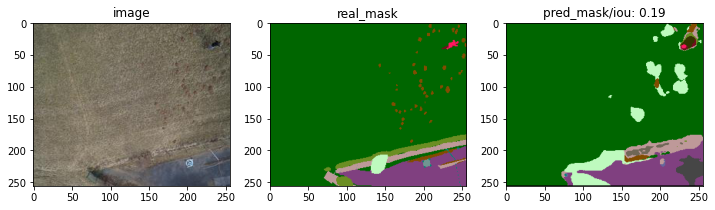

In [35]:
ShowResults(model)

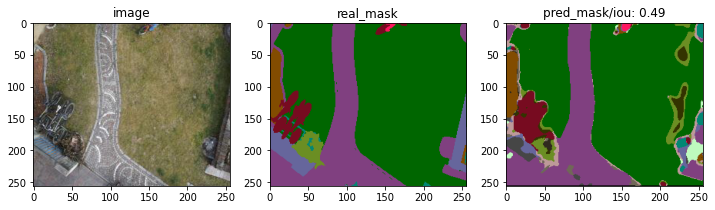

In [36]:
ShowResults(model)

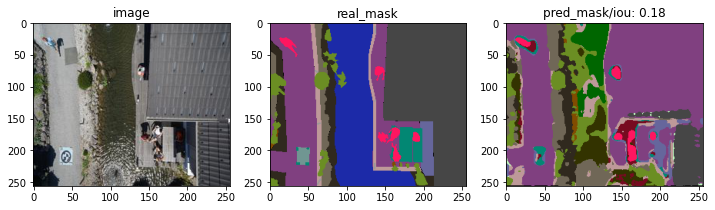

In [37]:
ShowResults(model)

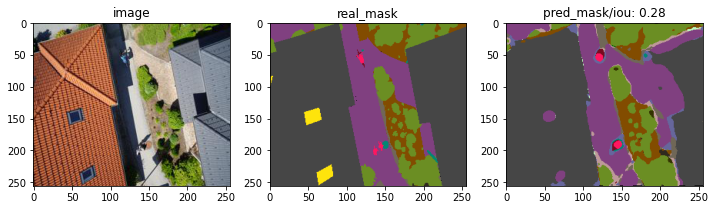

In [39]:
ShowResults(model)